# **Project Name**    -  Flight price prediction



##### **Project Type**    - Regression
##### **Contribution**    - Individual
##### **Author**          - Aparna Praturi


# **Project Summary -**

This project aims to predict the flight prices given inputs such as origin, destination, flightType, agency and flight date.

Exploratory data analysis of the flight prices  revealed that flight prices are slightly right-skewed, with a median of $900. Flight type, distance, and time significantly influence pricing, with first-class flights having the highest fares. Market share analysis showed Rainbow and CloudFy dominate with 43% each, while Flying Drops focuses solely on first-class flights (14.3%). City-wise analysis identified Florianopolis as the busiest hub and Rio de Janeiro as the least popular.

Feature engineering and preprocessing included extracting date, month, year and weekend from the date, scaling the numerical features, cyclical encoding periodoc features and one hot encoding the sategorical features.

To streamline the preprocessing step and maintain consistency, a Pipeline was created and used.

A predictive model was developed and tested using linear regression, ridge regression, and decision tree algorithms. The decision tree model, after hyperparameter tuning, achieved the best performance with an MAE of 32 and an R² of 98.6, indicating excellent prediction accuracy.

The streamlit app for this prediction system is available in the github repository.

# **GitHub Link -**

https://github.com/Aparna-Praturi/Flight-price-prediction

# **Problem Statement**


The objective of this project is to predict flight prices based on various features such as flight type, distance, time, and other factors. Accurate price predictions are critical for airlines to optimize pricing strategies, enhance customer satisfaction, and maintain competitive market positioning.




## ***1. Knowing Data***

### Import Libraries

In [1]:
!pip install shap

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold


import shap
import pickle
import joblib

### Dataset Loading

In [3]:
# Mounting drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Defining the path to data file

path = '/content/drive/MyDrive/Data science/Datasets/travel_capstone/flights.csv'

# Loading data to df

try:

  df_1 = pd.read_csv(f'{path}')

  print("Data loaded successfully!")

except FileNotFoundError:
    print(f"Error: The file(s) at {path} were not found. Please check the path.")

except pd.errors.EmptyDataError:
    print(f"Error: The file(s) at {path} is empty. Please check the file content.")

except pd.errors.ParserError:
    print(f"Error: There was a problem parsing the file(s) at {path}. Please check the file(s) format.")

except Exception as e:
    print(f"An unexpected error occurred: {e}")




Data loaded successfully!


### Dataset First View

In [5]:
# Make a copy of dataset for first look and  visualisation part

df = df_1.copy()

In [6]:
# Dataset First Look

df.head(10)

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,09/26/2019
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,09/30/2019
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,10/03/2019
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,10/04/2019
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,10/10/2019
5,2,0,Salvador (BH),Aracaju (SE),firstClass,1531.92,2.16,830.86,CloudFy,10/12/2019
6,3,0,Aracaju (SE),Campo Grande (MS),economic,743.54,1.69,650.10,Rainbow,10/17/2019
7,3,0,Campo Grande (MS),Aracaju (SE),economic,877.56,1.69,650.10,Rainbow,10/20/2019
8,4,0,Recife (PE),Florianopolis (SC),economic,803.39,1.76,676.53,Rainbow,10/24/2019
9,4,0,Florianopolis (SC),Recife (PE),economic,695.30,1.76,676.53,Rainbow,10/26/2019


### Dataset Rows & Columns count

In [7]:
# Dataset Rows & Columns count

df.shape

(271888, 10)

### Dataset Information

In [8]:
# Dataset Info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271888 entries, 0 to 271887
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   travelCode  271888 non-null  int64  
 1   userCode    271888 non-null  int64  
 2   from        271888 non-null  object 
 3   to          271888 non-null  object 
 4   flightType  271888 non-null  object 
 5   price       271888 non-null  float64
 6   time        271888 non-null  float64
 7   distance    271888 non-null  float64
 8   agency      271888 non-null  object 
 9   date        271888 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 20.7+ MB


#### Duplicate Values

In [9]:
# Dataset Duplicate Value Count

len(df[df.duplicated()])

0

#### Missing Values/Null Values

In [10]:
# Missing Values/Null Values Count

df.isnull().sum()

,0
travelCode,0
userCode,0
from,0
to,0
flightType,0
price,0
time,0
distance,0
agency,0
date,0


The dataset has 271888 rows and 10 columns. The dataset appears clean with no missing data and no duplicated data.

## ***2. Understanding Variables***

In [11]:
# Dataset Columns

df.columns

Index(['travelCode', 'userCode', 'from', 'to', 'flightType', 'price', 'time',
       'distance', 'agency', 'date'],
      dtype='object')

### Variables Description

#### Definitions of the variables:

1. **travelCode** : A unique numeric code for each booking.

2. **userCode**: A unique numeric code for individual users.

3. **from** : The origin city of the flight.

4. **to** : the destination city of the flight.

5. **flightType**: The type of flight .(Economy/First class/ Premium)

6. **price** : The flight fare for the trip. (Target variable)

7. **distance** : The distance covered by flight in the trip.

8. **time** : the time taken by the flight to complete the trip

9. **agency** : The flight agency responsible for the trip.

10. **date** : The date of the trip.

In [12]:
# Understanding the basic statistics of the numeric columns

df.describe()

,travelCode,userCode,price,time,distance
count,271888.000000,271888.000000,271888.00000,271888.000000,271888.000000
mean,67971.500000,667.505495,957.37503,1.421147,546.955535
std,39243.724665,389.523127,362.31189,0.542541,208.851288
min,0.000000,0.000000,301.51000,0.440000,168.220000
25%,33985.750000,326.000000,672.66000,1.040000,401.660000
50%,67971.500000,659.000000,904.00000,1.460000,562.140000
75%,101957.250000,1011.000000,1222.24000,1.760000,676.530000
max,135943.000000,1339.000000,1754.17000,2.440000,937.770000


### Checking Unique Values for each variable.

In [13]:
# Check Unique Values for each variable.

for i in df.columns:
  print(f' {i} : {df[i].nunique()}')

 travelCode : 135944
 userCode : 1335
 from : 9
 to : 9
 flightType : 3
 price : 490
 time : 33
 distance : 35
 agency : 3
 date : 999


In [14]:
# See the unique values of origin,destination, flight type and agency

print(f"Origins: {df['from'].unique()}")

print(f"Destinations : {df['to'].unique()}")
print(f" Flight types : {df['flightType'].unique()}")
print(f" Agency : {df['agency'].unique()}")

Origins: ['Recife (PE)' 'Florianopolis (SC)' 'Brasilia (DF)' 'Aracaju (SE)'
 'Salvador (BH)' 'Campo Grande (MS)' 'Sao Paulo (SP)' 'Natal (RN)'
 'Rio de Janeiro (RJ)']
Destinations : ['Florianopolis (SC)' 'Recife (PE)' 'Brasilia (DF)' 'Salvador (BH)'
 'Aracaju (SE)' 'Campo Grande (MS)' 'Sao Paulo (SP)' 'Natal (RN)'
 'Rio de Janeiro (RJ)']
 Flight types : ['firstClass' 'economic' 'premium']
 Agency : ['FlyingDrops' 'CloudFy' 'Rainbow']


## Part - 1 : Exploratory Data Analysis

### 1. Data wrangling for EDA

We do some data wrangling here to extract more details for our EDA.

In [15]:
#  Define a function to Extract year, month, weekday, and date from the date

def extract_from_date(df, date_col):

    df['date'] = pd.to_datetime(df['date'], format = "%m/%d/%Y")
    df['Year'] = df[date_col].dt.year.astype(int)
    df['Month'] = df[date_col].dt.month.astype(int)
    df['Day'] = df[date_col].dt.day.astype(int)
    df['weekday'] = df[date_col].dt.weekday.astype(int)
    df['is_weekend'] = np.where(df['weekday'].isin([5,6]), 1, 0).astype(int)

    #df.drop(columns = date_col, inplace = True)

    return


In [16]:
extract_from_date(df, 'date')

In [17]:
# checking unique values of date, month, weekday and year

print(len(df['Year'].unique()))
print(len(df['Month'].unique()))
print(len(df['Day'].unique()))
print(len(df['weekday'].unique()))

5
12
31
5


In [18]:
df.head()

,travelCode,userCode,from,to,flightType,price,time,distance,agency,date,Year,Month,Day,weekday,is_weekend
0,0,0,Recife (PE),Florianopolis (SC),firstClass,1434.38,1.76,676.53,FlyingDrops,2019-09-26,2019,9,26,3,0
1,0,0,Florianopolis (SC),Recife (PE),firstClass,1292.29,1.76,676.53,FlyingDrops,2019-09-30,2019,9,30,0,0
2,1,0,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,1.66,637.56,CloudFy,2019-10-03,2019,10,3,3,0
3,1,0,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,1.66,637.56,CloudFy,2019-10-04,2019,10,4,4,0
4,2,0,Aracaju (SE),Salvador (BH),firstClass,1684.05,2.16,830.86,CloudFy,2019-10-10,2019,10,10,3,0


Therefore,  have converted the date to a date_time object and extracted the year, month, weekday, and date to separate variables to enable detailed analysis.


### 2. Data Visualisation

We perform EDA to gain deeper insights into the data.

#### Chart - 1 :  How are the flight prices distributed? Are there outliers in the flight prices?

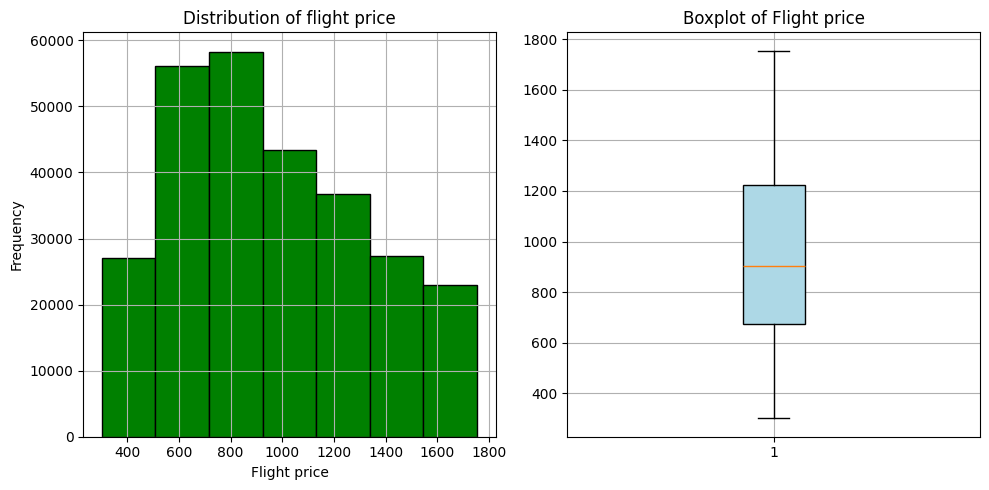

In [19]:
# Chart - 1 visualization code

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Histogram
axs[0].hist(df['price'], bins=7, color='green', edgecolor='black')
axs[0].set_xlabel('Flight price')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of flight price')
axs[0].grid(True)

# Boxplot
axs[1].boxplot(df['price'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].set_title('Boxplot of Flight price')
axs[1].grid(True)

# Show the plots

plt.tight_layout()

plt.show()



##### Insights:

The flight prices are approximately  normally distributed with median of about $900. There are no outliers in the fares. The boxplot is slightly left skewed indicating that the median is less than the mean implying a slight right skew in the flight prices.

#### Chart - 2:  What is the distribution of distance covered in each flight and that of the time taken by each flight?

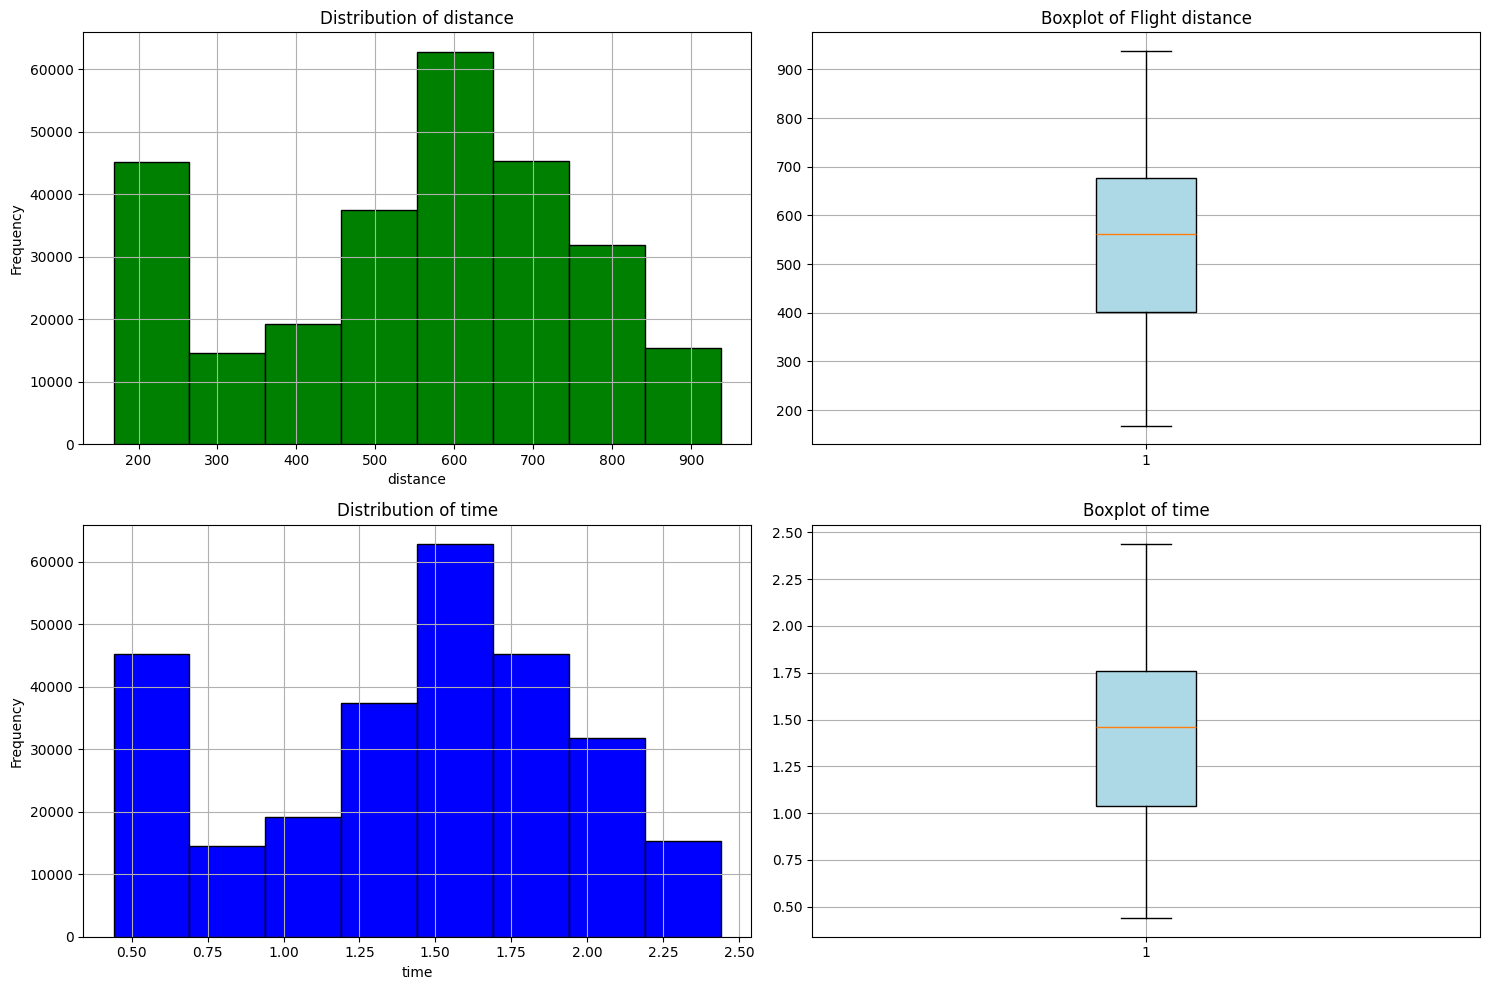

In [20]:
# Chart - 2 visualization code


# Create subplots

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs = axs.flatten()
# Histogram
axs[0].hist(df['distance'], bins=8, color='green', edgecolor='black')
axs[0].set_xlabel('distance')
axs[0].set_ylabel('Frequency')
axs[0].set_title(f'Distribution of distance')
axs[0].grid(True)

# Boxplot
axs[1].boxplot(df['distance'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].set_title('Boxplot of Flight distance')
axs[1].grid(True)

axs[2].hist(df['time'], bins=8, color='blue', edgecolor='black')
axs[2].set_xlabel('time')
axs[2].set_ylabel('Frequency')
axs[2].set_title(f'Distribution of time')
axs[2].grid(True)

# Boxplot
axs[3].boxplot(df['time'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[3].set_title('Boxplot of time')
axs[3].grid(True)


# Show the plots

plt.tight_layout()
plt.show()




##### Insights

Both distance and time are similarly distributed with no outliers. The histograms show a normal like distribution but with a slight left skew. The median distance is about 570km whereas the median time is about 1.4 hrs.

#### Chart - 3:  What is the median number of trips customers took in the given dataset? Are there customers who took unusually high number of trips?

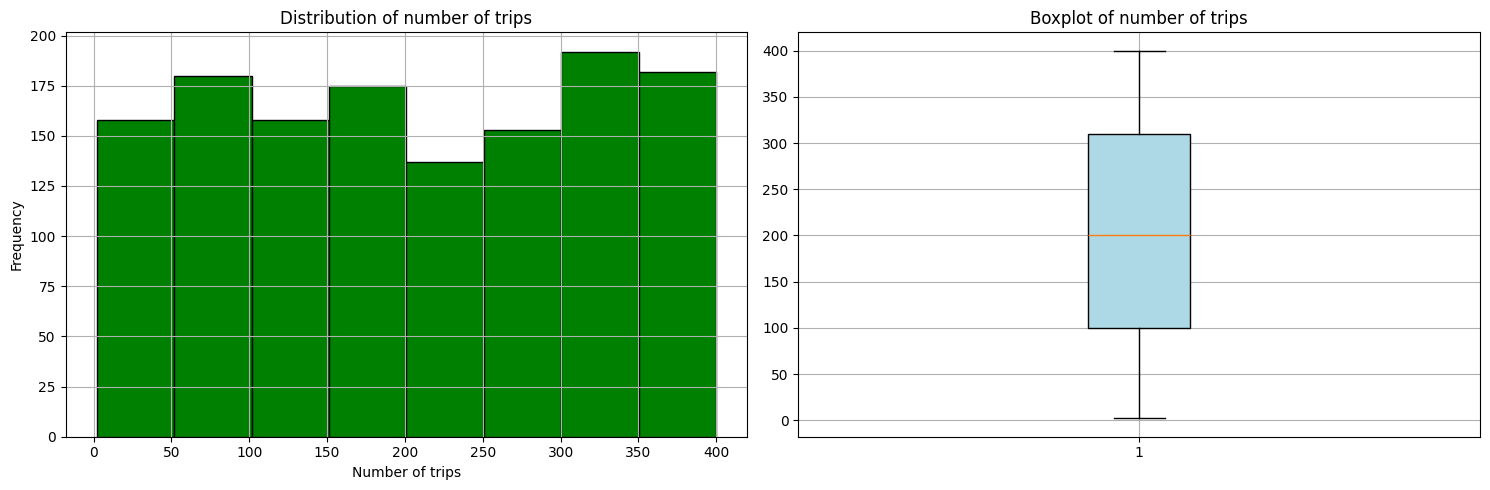

In [21]:
trips_per_user = df.groupby('userCode').size()

# creating subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plotting histogram

trips_per_user.hist(bins = 8, ax=axs[0], color='green', edgecolor='black')
axs[0].set_xlabel('Number of trips')
axs[0].set_ylabel('Frequency')
axs[0].set_title(f'Distribution of number of trips')
axs[0].grid(True)

# plotting boxplot

axs[1].boxplot(trips_per_user, patch_artist=True, boxprops=dict(facecolor='lightblue'))
axs[1].set_title('Boxplot of number of trips')
axs[1].grid(True)

# showing plots
plt.tight_layout()
plt.show()

##### Insights:

The number of trips taken by customers appears to be an uniform distribution. The average customer took about 200 trips in the given timeframe. There are no customers taking unusually high number of trips.

#### Chart - 4:  Which flight agency undertook the maximum/minimum percentage of flights? Did all flight agencies run flights of all types?

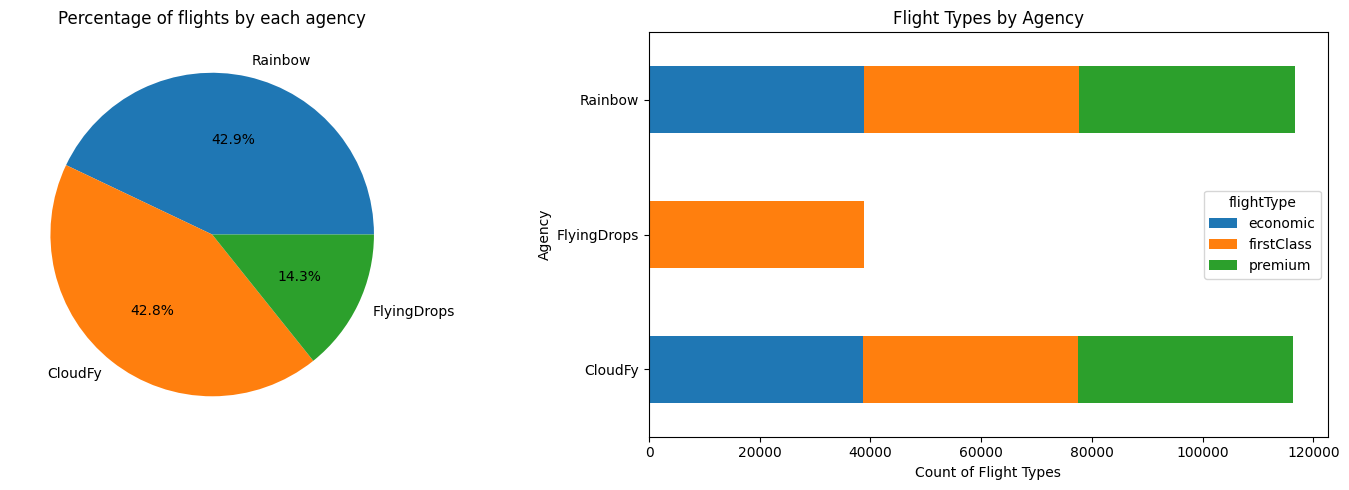

In [22]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs=axs.flatten()

# creating pie chart

axs[0].pie(df['agency'].value_counts(), labels=df['agency'].value_counts().index , autopct='%1.1f%%')

axs[0].set_title('Percentage of flights by each agency')


# plotting stacked bar chart

pivot = df.groupby(['agency', 'flightType']).size().unstack(fill_value=0)

pivot.plot(kind='barh', stacked=True, ax=axs[1])

# Adding labels and title
axs[1].set_ylabel('Agency')
axs[1].set_xlabel('Count of Flight Types')
axs[1].set_title('Flight Types by Agency')

# Show the plots
plt.tight_layout()
plt.show()



##### Insights:

While Rainbow and CloudFy each took about 43% of total flights, Flying Drops is responsible for only 14.3% of all flights.

Moreover, whereas Rainbow and Cloudfy ran flights economic, firstclass and premium types in almost equal number, FlyingDrops only ran firstclass flights.

#### Chart - 5:  Which flight type is least expensive? What is the median fare offered by different agencies?

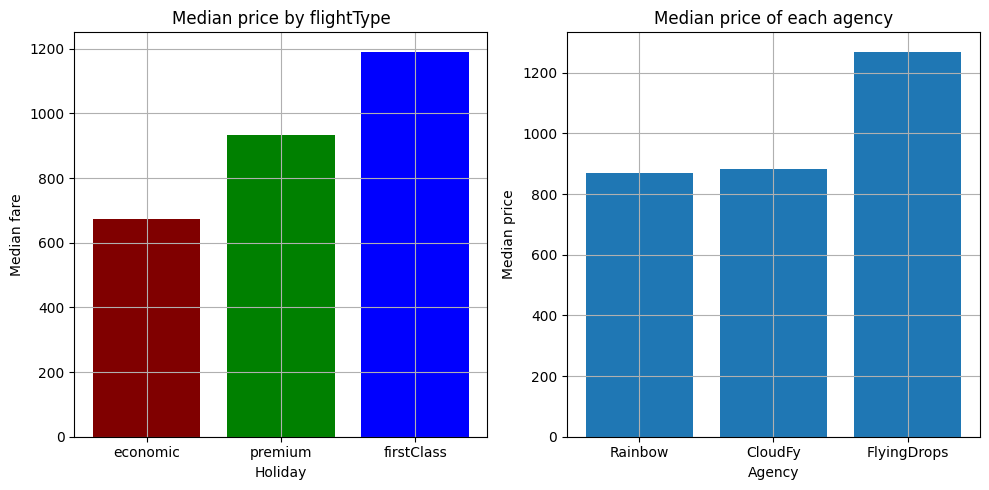

In [23]:
# Chart - 4 visualization code

# Create subplots

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Barplot

x = df.groupby('agency')['price'].median().sort_values().index
y = df.groupby('agency')['price'].median().sort_values()

axs[1].bar(height=y, x=x)
axs[1].set_xlabel('Agency')
axs[1].set_ylabel('Median price')
axs[1].set_title('Median price of each agency')
axs[1].grid(True)

# Barplot
x = df.groupby('flightType')['price'].median().sort_values().index
y = df.groupby('flightType')['price'].median().sort_values()

axs[0].bar(height=y, x=x, color=['maroon', 'green', 'blue'])
axs[0].set_xlabel('Holiday')
axs[0].set_ylabel('Median fare')
axs[0].set_title('Median price by flightType')
axs[0].grid(True)


# Barplot

# Show the plots
plt.tight_layout()
plt.show()

##### Insights:

The median flight fare of economic flights is about \$650,  \$900 for premium and almost $1200 for first class flights.

While Rainbow and cloudy offer flights with median fare of about \$850,FlyingDrops which runs only first class flights has a median fare of over \$1200.

#### Chart - 6 : Which type of flight is most popular? What is the total distance travelled by flights of each agency?

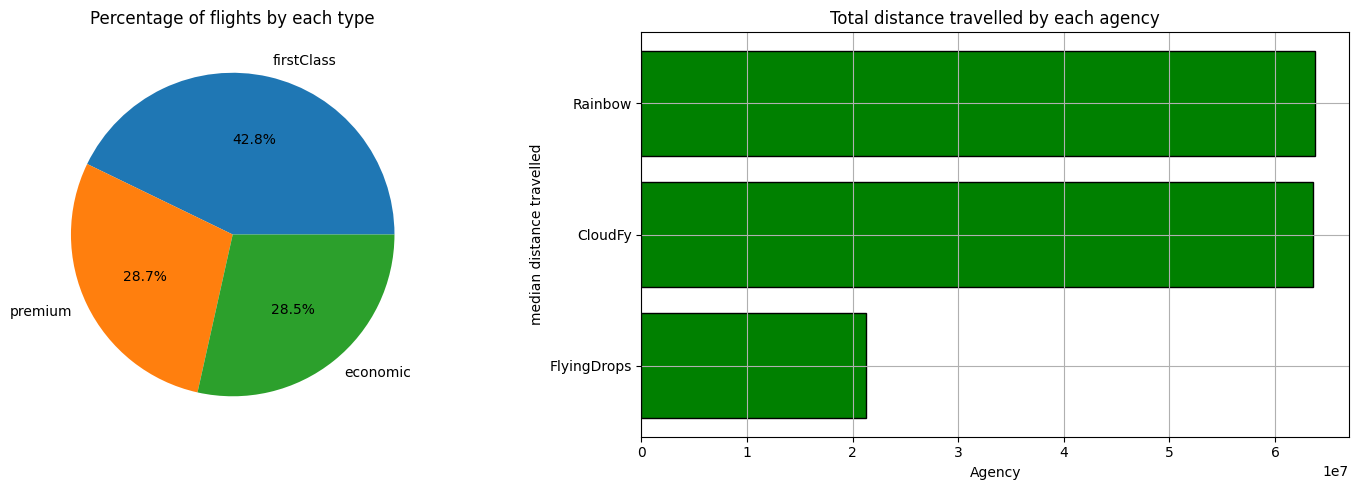

In [24]:
# Chart - 4 visualization code

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Barplot
x1 = df.groupby('agency')['distance'].sum().sort_values().index
y1 = df.groupby('agency')['distance'].sum().sort_values()

axs[1].barh(width=y1, y=x1, color='green', edgecolor='black')
axs[1].set_xlabel('Agency')
axs[1].set_ylabel('median distance travelled')
axs[1].set_title('Total distance travelled by each agency')
axs[1].grid(True)


# Boxplot
axs[0].pie(df['flightType'].value_counts(), labels=df['flightType'].value_counts().index , autopct='%1.1f%%')

axs[0].set_title('Percentage of flights by each type')

# Show the plots
plt.tight_layout()
plt.show()



##### Insights:

Firstclass flights are most popular consisting of 42% of all flights.The premium and economic flights each contribute to about 29% of the total flights.

While Rainbow and cloudfy each travelled above 6000000km, Flyingdrops with its fleet of exclusively firstclass flights travelled just over 2000000 km.

#### Chart - 7 : Which city has the maximum flights originating from it? Which city is the most popular destination? Is there any city with discrepancy in number of flights starting from it and reaching it?

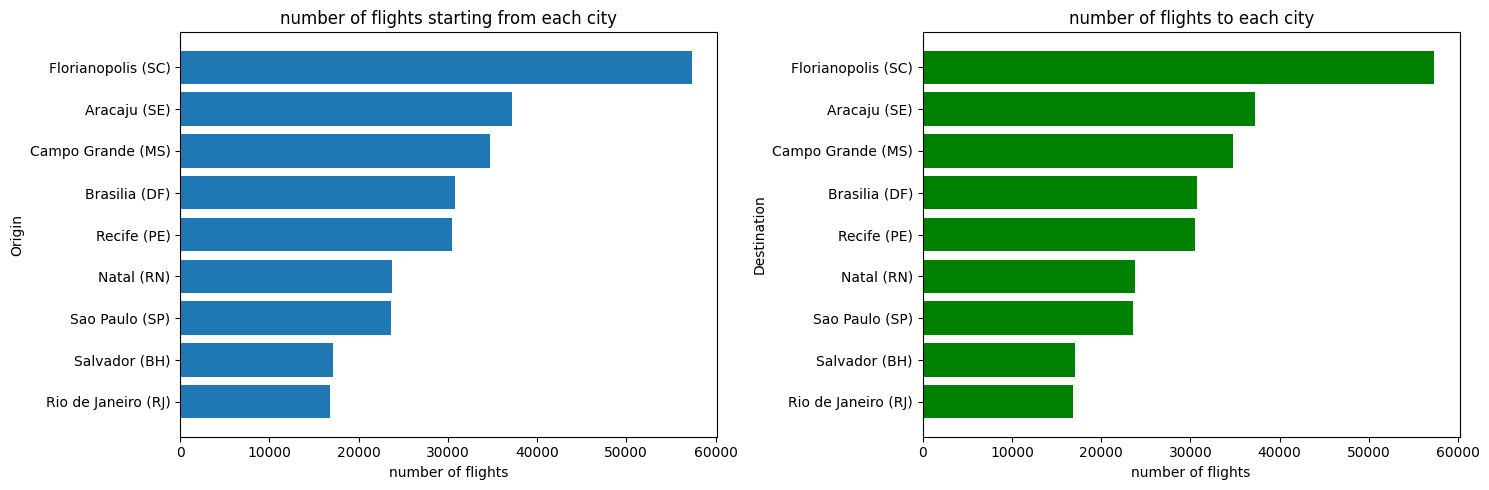

from
Rio de Janeiro (RJ)    0
Salvador (BH)          0
Sao Paulo (SP)         0
Natal (RN)             0
Recife (PE)            0
Brasilia (DF)          0
Campo Grande (MS)      0
Aracaju (SE)           0
Florianopolis (SC)     0
dtype: int64


In [25]:
# plotting subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plotting barplot 1

y = df.groupby('from').size().sort_values()
x = df.groupby('from').size().sort_values().index

axs[0].barh(y=x, width=y)
axs[0].set_ylabel('Origin')
axs[0].set_xlabel('number of flights')
axs[0].set_title('number of flights starting from each city')

# plotting barplot 2

y1 = df.groupby('to').size().sort_values()
x1 = df.groupby('to').size().sort_values().index

axs[1].barh(y=x1, width=y1, color='green')
axs[1].set_ylabel('Destination')
axs[1].set_xlabel('number of flights')
axs[1].set_title('number of flights to each city')

# Show the plots
plt.tight_layout()
plt.show()

# Calculating difference in # flights starting and reaching each city?

print(y-y1)



##### Insights:

Florianopolis is the most popular city with almost 60000 flights starting from and reaching it. Whereas, rio de janerio is the least popular with only about 17000 dlights to and from it.

For all the cities, the number of flights reaching the city is equal to the number of flights leaving the city.

#### Chart - 8: How do flight prices fluctuate over the course of an year? Are there any changes in flight prices over the years?

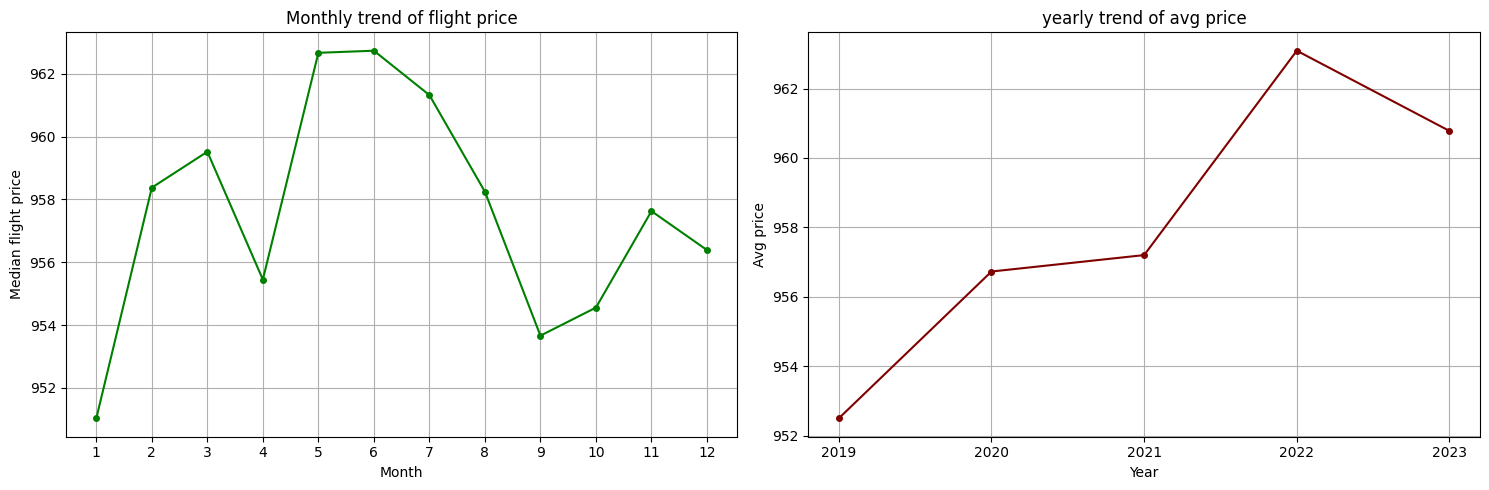

In [26]:
# Chart - 5 visualization code

# creating subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# grouping the data by month

x_month = df.groupby('Month')['price'].mean().index
y_month = df.groupby('Month')['price'].mean()

# plotting month trend

axs[0].plot(x_month, y_month, marker='o', markersize=4, color='green')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Median flight price')
axs[0].set_xticks(np.arange(1, 13))
axs[0].set_title('Monthly trend of flight price')
axs[0].grid()


# grouping the data by year

x_year = df.groupby('Year')['price'].mean().index
y_year = df.groupby('Year')['price'].mean()

# plotting year trend
axs[1].plot(x_year, y_year, marker='o', markersize=4, color='maroon' )
axs[1].set_xlabel('Year')
axs[1].set_xticks([2019, 2020, 2021, 2022, 2023])
axs[1].set_ylabel('Avg price')
axs[1].set_title('yearly trend of avg price')
axs[1].grid()

# showing plots

plt.tight_layout()

plt.show()

##### Insights:

The flight prices see small fluctuations over months. While prices are lowest in January with a median of \$950, they are highest in May and June with \$963.

The flight prices saw an overall increasing trendfrom the years 2019-2023. They reached a maximum of \$963 in 2022 from \$952 in 2019,  which fell very slightly to \$960 in 2023.

#### Chart - 9 : Which day of the week has the lowest flight fare? Are weekend fares higher than weekday fares?

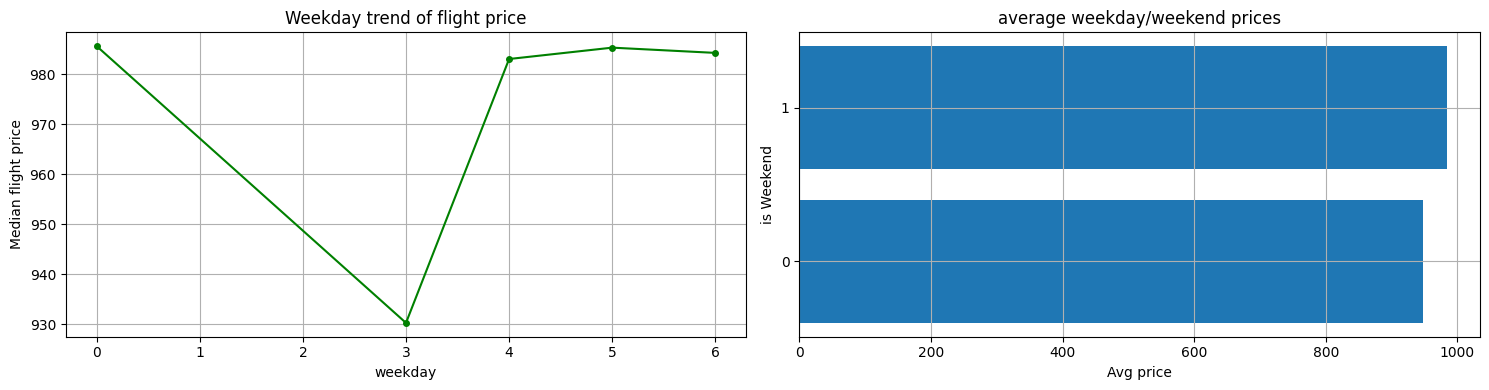

In [27]:
# creating subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# grouping the data by days of the week

x_weekday = df.groupby('weekday')['price'].mean().index
y_weekday = df.groupby('weekday')['price'].mean()

# plotting daily

axs[0].plot(x_weekday, y_weekday, marker='o', markersize=4, color='green')
axs[0].set_xlabel('weekday')
axs[0].set_ylabel('Median flight price')
axs[0].set_title('Weekday trend of flight price')
axs[0].grid()


# grouping the data by is_weekend

x_year = df.groupby('is_weekend')['price'].mean().index
y_year = df.groupby('is_weekend')['price'].mean()

# plotting weekend trend
axs[1].barh(y=x_year, width=y_year )
axs[1].set_ylabel('is Weekend')
axs[1].set_yticks([0,1])
axs[1].set_xlabel('Avg price')
axs[1].set_title('average weekday/weekend prices')
axs[1].grid()

# showing plots

plt.tight_layout()

plt.show()

#### Insights:

Thursday has the lowest median fare of \$930 whereas monday has the highest of over \$985.

The fares on weekend are slightly higher than on weekdays.

#### Chart - 10 : How is does the flight fare change with distance and time taken by the flight? How are time and distance related to each other?

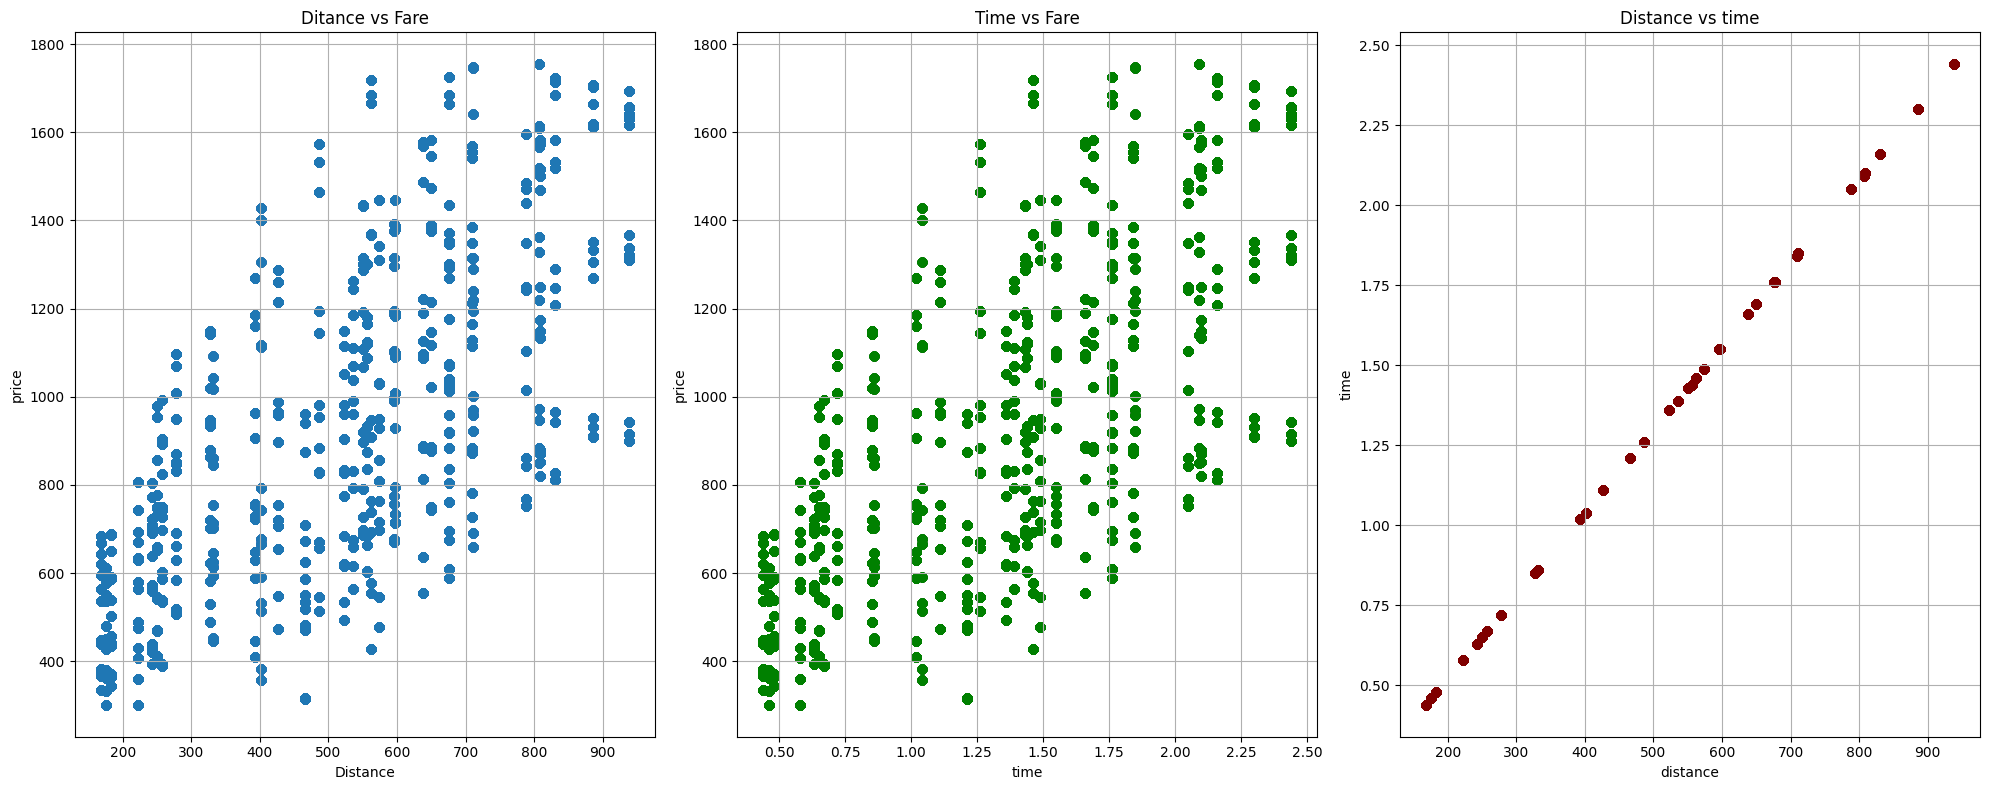

In [28]:
# Chart - 7 visualization code

# Create subplots
fig, axs = plt.subplots(1,3, figsize=(20, 8))

axs=axs.flatten()

# plotting distance vs fare
axs[0].scatter(df['distance'], df['price'], alpha=0.5)
axs[0].set_xlabel('Distance')
axs[0].set_ylabel('price')
axs[0].set_title(f'Ditance vs Fare')
axs[0].grid(True)

# plotting time vs fare
axs[1].scatter(df['time'], df['price'], alpha=0.5, color='green')
axs[1].set_xlabel('time')
axs[1].set_ylabel('price')
axs[1].set_title(f'Time vs Fare')
axs[1].grid(True)

# plotting time vs distance

axs[2].scatter(df['distance'], df['time'], alpha=0.5, color='maroon')
axs[2].set_xlabel('distance')
axs[2].set_ylabel('time')
axs[2].set_title(f'Distance vs time')
axs[2].grid(True)




# Show the plots
plt.tight_layout()
plt.show()

##### Insights:

The flight price is positively related with both time and distance.

Time and distance are linearly related to each other, making one of them redundant.


#### Chart - 11 : Are all the cities in the dataset connected to each other by direct flights? Do all agencies run flights to and from all cities?

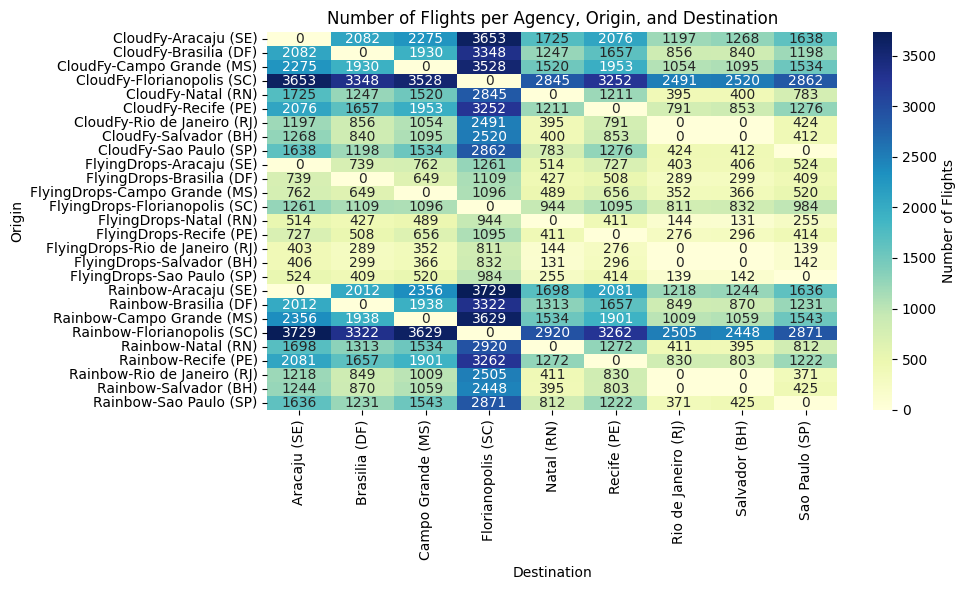

In [29]:

# Count the number of flights per (agency, origin, destination)
flight_counts = df.groupby(['agency', 'from', 'to']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(flight_counts, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={'label': 'Number of Flights'})

# Adding labels and title
plt.title('Number of Flights per Agency, Origin, and Destination')
plt.xlabel('Destination')
plt.ylabel('Origin')

# Display the plot
plt.tight_layout()
plt.show()


#### Insights:

From the heatmap, we see that all the cities except Rio de Janerio and Salvador have direct flights to each other.
We also see that all flight agencies run flights to and from all cities except between Rio de Janerio and Salvador.

### 3. Hypothesis Testing


H0 : The average flight price on weekends is same as the price on weekdays.

H1 : The average flight price on weekends is NOT the same as price on weekdays

Statistical tests like t-test assume near-normal distributions. We have seen in Chart 1 above that the price is indeed near normal. However, we plot separate histograms for price of weekends and weekdays to verify whether the individual distributions of weekends and weekdays are also near-normal.

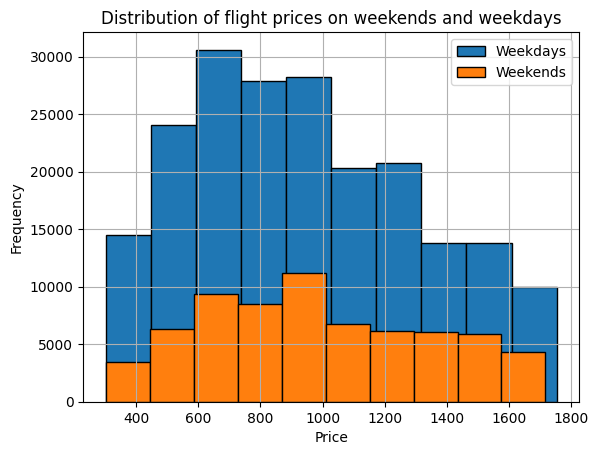

In [30]:
# plotting distributions of average price on weekends and weekdays

plt.hist(df[df['is_weekend']==0]['price'], bins=10, edgecolor='black')
plt.hist(df[df['is_weekend']==1]['price'], bins=10, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of flight prices on weekends and weekdays')
plt.grid(True)
plt.legend(['Weekdays', 'Weekends'])

plt.show()


As the individual distributions for weekday prices and weekend prices are near-normal and the sample sizes are comparable, we go ahead with performing the statistical tests.

In [31]:
# Perform t-test to obtain P-Value

# Making different datasets for weekends and weekdays

df_weekday = df[df['is_weekend']==0]
df_weekend = df[df['is_weekend']==1]

# Performong t-test to check if there is significant difference in means

t_statistic, p_value = stats.ttest_ind(df_weekday['price'], df_weekend['price'])

print("T-statistic:", t_statistic)
print("P-value:", p_value)


# Interpret the result
alpha = 0.05

if p_value < alpha:
    print(f"Reject the null hypothesis: The mean flight price varies significantly between weekends and weekdays.")
else:
    print(f"Fail to reject the null hypothesis: The mean flight price DOES NOT vary significantly between weekends and weekdays.")


T-statistic: -22.7647995599556
P-value: 1.31168352072033e-114
Reject the null hypothesis: The mean flight price varies significantly between weekends and weekdays.


## Part : 2 Regression model building for price prediction

#### 1. Feature selection

1. We see that features 'userCode' and 'travelCode' are irrelevant for model building.

2. From EDA it is clear that 'time' and 'distance' are perfectly correlated making one of them redundant.

Therefore, we drop these columns from the dataset

In [32]:
drop_cols = ['travelCode', 'userCode', 'time']

modified_df = df_1.drop(drop_cols, axis=1)

In [33]:
modified_df.head()

,from,to,flightType,price,distance,agency,date
0,Recife (PE),Florianopolis (SC),firstClass,1434.38,676.53,FlyingDrops,09/26/2019
1,Florianopolis (SC),Recife (PE),firstClass,1292.29,676.53,FlyingDrops,09/30/2019
2,Brasilia (DF),Florianopolis (SC),firstClass,1487.52,637.56,CloudFy,10/03/2019
3,Florianopolis (SC),Brasilia (DF),firstClass,1127.36,637.56,CloudFy,10/04/2019
4,Aracaju (SE),Salvador (BH),firstClass,1684.05,830.86,CloudFy,10/10/2019


### 2. Feature manipulation

Extracting day, month, year and weekday from the date would be useful.

Adding a new feature of 'is_weekend' is also useful to determine whether a given date is a weekend or not.

In [34]:

class DateExtractor(BaseEstimator, TransformerMixin):

  """ This class extracts day, month, year and
   weekday from the date_col of a given df, makes a new feature
   'is_weekend' and returns the modified dataframe """

  def __init__(self, date_col):
        self.date_col = date_col

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        X_copy = X.copy()
        X_copy[self.date_col] = pd.to_datetime(X_copy[self.date_col])
        X_copy['Day'] = X_copy[self.date_col].dt.day
        X_copy['Month'] = X_copy[self.date_col].dt.month
        X_copy['Year'] = X_copy[self.date_col].dt.year
        X_copy['weekday'] = X_copy[self.date_col].dt.weekday
        X_copy['is_weekend'] = np.where(X_copy['weekday'].isin([5, 6]), 1, 0).astype(int)

        X_copy = X_copy.drop(columns=[self.date_col])

        return X_copy

### 3. Classes for Encoding categorical and cyclical features

Next, we make a class to encode categorical variables using one hot encoding.

In [35]:
class CatEncoder(BaseEstimator, TransformerMixin):

    """ This class encodes given categorical variables in adataframe using one hot encoding
    and returns modified df """

    def __init__(self, cat_features, encoder):
        self.cat_features = cat_features
        self.encoder = encoder

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        transformed_data = self.encoder.transform(X_copy[cat_features])
        transformed_df = pd.DataFrame(transformed_data, columns=self.encoder.get_feature_names_out(self.cat_features))
        transformed_df.index = X_copy.index
        # Drop the original categorical columns and concatenate the new encoded columns
        X_copy = X_copy.drop(columns=self.cat_features).join(transformed_df)
        #X_copy = pd.concat([X_copy, transformed_df], axis=1)


        return X_copy

We then create a class to perform cyclical encoding over the cyclical features like Day, Month and weekday.

In [36]:
class CycEncoder(BaseEstimator, TransformerMixin):

  """ This class performs cyclical encoding over the cyclical features like Day, Month and weekday
      and returns modified df """

  def __init__(self, cyc_features):
      self.cyc_features = cyc_features

  def fit(self, X, y=None):
        return self

  def transform(self, X):
        X_copy = X.copy()
        for feature, max_value in self.cyc_features.items():
            X_copy[feature + '_sin'] = np.sin(2 * np.pi * X_copy[feature] / max_value)
            X_copy[feature + '_cos'] = np.cos(2 * np.pi * X_copy[feature] / max_value)
            X_copy = X_copy.drop(columns=[feature])
        return X_copy

### 4. Class for Scaling of numerical features

Finally, we create a class to scale the numeric features using Standard Scaler.



In [37]:
class num_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, num_features, scaler):

        self.num_features = num_features
        self.scaler = scaler

    def fit(self, X, y=None):
       return self

    def transform(self, X):

        X_copy = X.copy()
        X_num = X_copy[self.num_features]
        X_scaled = self.scaler.transform(X_num)
        X_scaled_df = pd.DataFrame(X_scaled, columns=self.num_features, index=X_copy.index)
        df_scaled = X_copy.drop(columns=self.num_features).join(X_scaled_df)

        return df_scaled

### 5. Function for Splitting the data into train and test sets

In [38]:
# Function to split the data to train and test sets

def extract_train_test(df, test_size, random_state):

  X = df.drop(columns = ['price'], axis=1)
  Y = df['price']

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

  return X_train, X_test, y_train, y_test



### 6. Function for Fitting the training data to the Standard Scaler.

Here, we make sure to fit the standard scaler to the numerical features of train data only(not the test data) to ensure that there is no data leakage.

The same fit is then applied to both train and test data.

In [39]:
def scale_fit(X_train, num_features, scaler):

  # Applying date extractor on X_train to extract num_feature 'Year'

  date_transformer = DateExtractor(date_col='date')
  X_train_transformed = date_transformer.fit_transform(X_train)

 # Applying the standard scaler

  scaler = scaler
  fit = scaler.fit(X=X_train_transformed[num_features])

  return fit

In [40]:
from sklearn.preprocessing import OneHotEncoder
def cat_fit(X_train, cat_features):

  encoder = OneHotEncoder(handle_unknown='ignore')
  encoder.fit(X_train[cat_features])

  return encoder

### 7. Class for Model Training

In [41]:
class Model_training:

  """ This class performs model training using given models,
   calculates accuracy scores using given scoring method, plots the residuals,
    hyperparameter tuning for best model using given hyperparameters and returns the best model along with
    evaluation metrics. """

  def __init__(self, models=None, scoring=mean_absolute_error, cv=5, tune_best_model=True, param_grids={}):    ## 1. Initialise the class
    self.models = models
    self.scoring = scoring
    self.cv = cv
    self.tune_best_model = tune_best_model
    self.param_grids = param_grids if param_grids else {}
    self. evaluation_metrics = pd.DataFrame(index =['train_MSE', 'test_MSE', 'train_MAE', 'test_MAE','train_R2', 'test_R2'])

  # Function to plot residuals
  def plot(self, y_test, y_pred_test):
     residuals = y_test - y_pred_test
     fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # plot residuals
     axs[0].scatter(y_pred_test, y_test)
     axs[0].plot([min(y_pred_test), max(y_pred_test)], [min(y_pred_test), max(y_pred_test)], 'k--', lw=2)
     axs[0].set_xlabel('Predicted values')
     axs[0].set_ylabel('Actual values')
     axs[0].set_title('Scatter plot of predicted vs actual values')
     axs[0].grid(True)
     axs[1].scatter(y_pred_test, residuals, color='blue', edgecolors='k', alpha=0.7)
     axs[1].axhline(y=0, color='black', linestyle='--')
     axs[1].set_title(f"Residuals")
     axs[1].set_xlabel('Predicted Values')
     axs[1].set_ylabel('Residuals')

     plt.tight_layout()
     plt.show()
     return

  # Function to calculate evaluation metrics
  def cal_eval(self,y,y_pred):
     mae = mean_absolute_error(y,y_pred)
     mse = mean_squared_error(y,y_pred)
     r2 = r2_score(y,y_pred)
     return mae, mse, r2


  # function to find best model
  def find_model(self, X_train, y_train, X_test, y_test):   ## 1. Define function to find best model
    # initialise best model parameters
    bestModel_score = float('inf')
    bestModel = None
    bestModel_name = None

   # loop through all models
    for name, model in self.models:
     print(f"Training {name} model...")
     model.fit(X_train, y_train)  # Fit the model

     # Predict train and test target variable
     y_pred_train = model.predict(X_train)
     y_pred_test = model.predict(X_test)

     # evaluate the model
     train_score, train_mse, train_r2 = self.cal_eval(y_train, y_pred_train)
     test_score, test_mse, test_r2 = self.cal_eval(y_test, y_pred_test)

     print(f"{name} train score: {train_score}")
     print(f"{name} score: {test_score}")

     # plot residuals
     self.plot(y_test, y_pred_test)

     # update metrics table
     self.evaluation_metrics[name] = [train_score, test_score, train_mse, test_mse, train_r2, test_r2]

     # update the best model
     if test_score < bestModel_score:
      bestModel = model
      bestModel_score = test_score
      bestModel_name = name

    print(f"Best model: {bestModel_name} with Score: {bestModel_score}")  # print the best model
    #return bestModel, bestModel_name

  # Tune hyperparameters for best model
  #def tune_bestModel(self, bestModel_name, bestModel, X_train, y_train, X_test, y_test):
    if (bestModel_name in self.param_grids) and self.tune_best_model:
      print(f"Tuning hyperparameters for {bestModel_name}....")

      param_grid = self.param_grids[bestModel_name]
      grid_search = GridSearchCV(bestModel, param_grid, cv=self.cv, scoring='neg_mean_squared_error')# implement grid search
      grid_search.fit(X_train, y_train)
      best_model = grid_search.best_estimator_  # find best tuning

      # predict using the best tuned model
      y_pred_train_bestparam = best_model.predict(X_train)
      y_pred_test_bestparam = best_model.predict(X_test)

      # evaluate metrics
      train_score_best_param, train_mse, train_r2 = self.cal_eval(y_train, y_pred_train_bestparam)
      test_score_best_param, test_mse, test_r2 = self.cal_eval(y_test, y_pred_test_bestparam)
      print(f"Best Hyperparameters for {bestModel_name}: {best_model} with training eroor of {train_score_best_param} and testing error of{ test_score_best_param}")

      # plot
      self.plot(y_test, y_pred_test_bestparam)

      # update evaluation metrics table
      self.evaluation_metrics[f'{bestModel_name}-hyperparameter_tuned '] = [train_score_best_param, test_score_best_param, train_mse, test_mse, train_r2, test_r2]
      #return best_params, self.evaluation_metrics

    else:
      best_model = bestModel
      print(f"No tuning required for {bestModel_name}")
    return bestModel, self.evaluation_metrics

  ##  Call the class
  def  __call__(self, X_train, y_train, X_test, y_test):
     bestModel, bestModel_name = self.find_model(X_train, y_train, X_test, y_test)
     return bestModel, bestModel_name, self.evaluation_metrics


### 8. Declaring all the parameters for the current data

In [42]:
date_col = 'date'

cat_features = ['from', 'to', 'flightType', 'agency']
num_features = ['distance', 'Year']
cyc_features = {'Day': 31, 'Month': 12, 'weekday': 7}

models = [('Linear Regression', LinearRegression()),
                ('Ridge Regression', Ridge(alpha=0.1)),
               #('SVR', SVR()),
               #('KNN', KNeighborsRegressor()),
                ('Decision Tree', DecisionTreeRegressor(max_depth=15, max_features=20, max_leaf_nodes=80, random_state=42)),
               #('Random Forest', RandomForestRegressor(n_estimators=10, random_state=42))
               ]


param_grids = { 'Random Forest': {'n_estimators': [50, 100, 200],
                      'max_depth': [10, 20, 30, None]},

    'Ridge Regression': {'alpha': [0.1, 1, 10, 100] },

    'SVR': { 'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2] },

    'KNN': {'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']},

    'Decision Tree':{'max_depth': ( 10, 14, 16),
                    'max_features': (10, 20, 30),
                    'max_leaf_nodes': [30, 50, 100],
                    #'min_samples_leaf': [ 2, 4, 8, 10],
                    'random_state': [42] }
}


In [43]:
# defining Pipeline to streamline the preprocessing step

# Splitting the data to train and test sets
X_train, X_test, y_train, y_test = extract_train_test(modified_df, test_size=0.25, random_state=42)

# Fitting the numerical and categorical features of train data
fit = scale_fit(X_train, num_features, StandardScaler())
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_encoder.fit(modified_df[cat_features])

# creating the pipeline
preprocessor = Pipeline([
    ('date_features', DateExtractor(date_col=date_col)),
    ('num_encoding', num_scaler(num_features=num_features, scaler=fit)),
    ('cyclical_encoding', CycEncoder(cyc_features = cyc_features)),
    ('cat_encoding', CatEncoder(cat_features=cat_features, encoder=cat_encoder))])

# saving the preprocessor
path = '/content/drive/MyDrive/Data science/ML_Models/flight_price_preprocessor.pkl'
joblib.dump(preprocessor, path)


['/content/drive/MyDrive/Data science/ML_Models/flight_price_preprocessor.pkl']

### 9. Preprocessing

In [44]:
# Preprocessing the training and testing data separately to avoid data leakage.
processed_X_train = preprocessor.fit_transform(X_train)
processed_X_test = preprocessor.fit_transform(X_test)

In [45]:
# sanity check for preprocessed data
processed_X_train.head()

,is_weekend,distance,Year,Day_sin,Day_cos,Month_sin,Month_cos,weekday_sin,weekday_cos,from_Aracaju (SE),...,to_Recife (PE),to_Rio de Janeiro (RJ),to_Salvador (BH),to_Sao Paulo (SP),flightType_economic,flightType_firstClass,flightType_premium,agency_CloudFy,agency_FlyingDrops,agency_Rainbow
230046,0,0.433676,-0.533551,0.724793,0.688967,1.224647e-16,-1.000000e+00,0.433884,-0.900969,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
31870,0,0.017922,-1.554368,-0.848644,0.528964,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
77947,0,0.242478,-1.554368,0.724793,0.688967,-8.660254e-01,5.000000e-01,-0.433884,-0.900969,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
69869,0,0.042091,-1.554368,0.485302,-0.874347,-2.449294e-16,1.000000e+00,-0.433884,-0.900969,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
215948,0,-0.385963,-0.533551,-0.897805,-0.440394,5.000000e-01,-8.660254e-01,0.433884,-0.900969,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### 10. Model Training

Training Linear Regression model...
Linear Regression train score: 81.09742926901349
Linear Regression score: 80.95296542977056


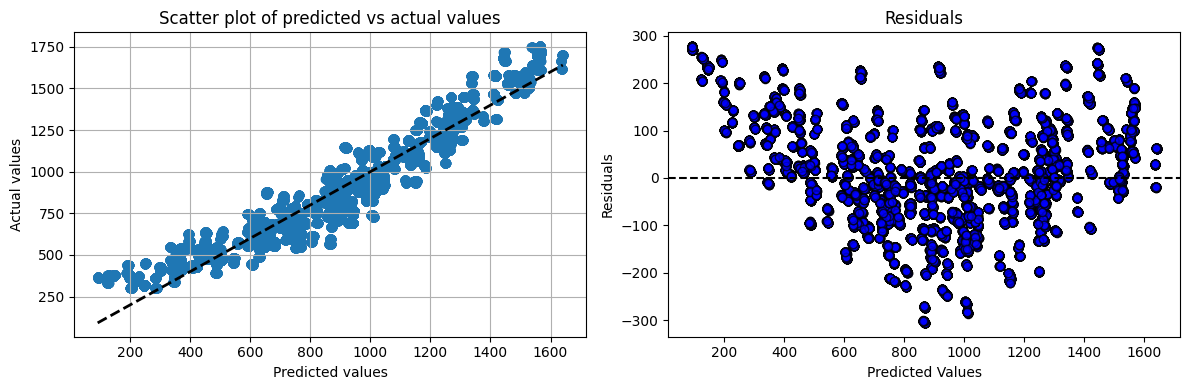

Training Ridge Regression model...
Ridge Regression train score: 81.09740350759536
Ridge Regression score: 80.95293790377946


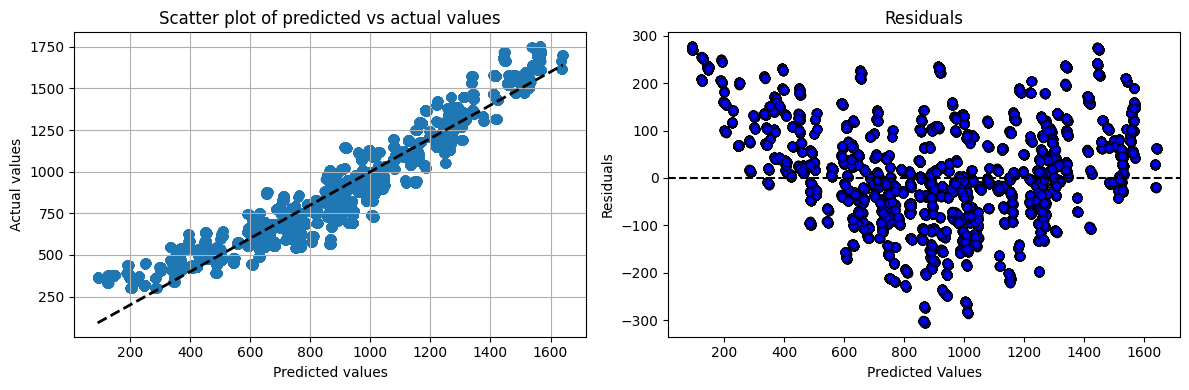

Training Decision Tree model...
Decision Tree train score: 40.59928995639825
Decision Tree score: 40.49736442037418


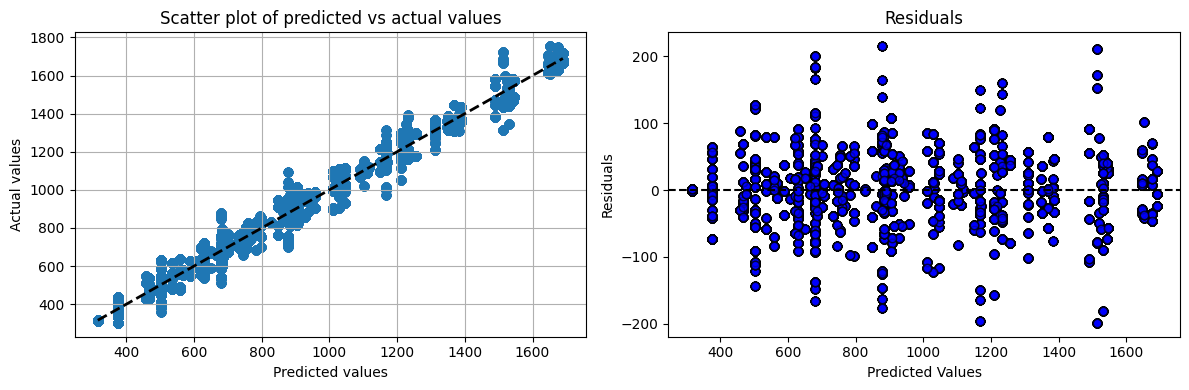

Best model: Decision Tree with Score: 40.49736442037418
Tuning hyperparameters for Decision Tree....
Best Hyperparameters for Decision Tree: DecisionTreeRegressor(max_depth=14, max_features=30, max_leaf_nodes=100,
                      random_state=42) with training eroor of 31.422014402854565 and testing error of31.378784702419793


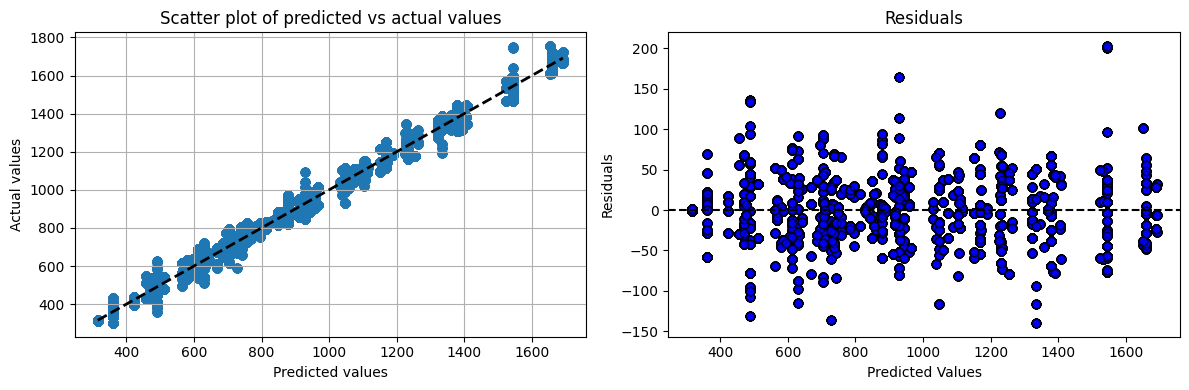

In [46]:
# training the model to obtain best model and evaluation metrics

model_training = Model_training(models=models,  scoring=mean_squared_error, cv=5, tune_best_model=True, param_grids=param_grids)

best_model,model_name, evaluation_metrics = model_training(processed_X_train, y_train, processed_X_test, y_test)

In [47]:
# Evaluation metrics

evaluation_metrics.transpose()

,train_MSE,test_MSE,train_MAE,test_MAE,train_R2,test_R2
Linear Regression,81.097429,80.952965,10594.059449,10568.550203,0.919209,0.919744
Ridge Regression,81.097404,80.952938,10594.059451,10568.549621,0.919209,0.919744
Decision Tree,40.599290,40.497364,2816.541939,2827.883993,0.978521,0.978525
Decision Tree-hyperparameter_tuned,31.422014,31.378785,1563.372421,1559.630043,0.988078,0.988156


We observe that decision tree outperforms linear regression by a factor of almost 10.

Out of all the evaluation metrics, we chose the mean squared error, MSE to be our scoring system because for a price prediction problem, the error in the predicted and actual price is the most important factor.

We obtained a very good model with r2 of 98% on both training and testing data.

**As both the training and testing error are very low and because we have preprocessed training and testing data separately, we can be confident that there is no overfitting or data leakage.**

### 11. Saving the preprocessor, model and other required data.

In [48]:
# Creating a dictionary to store all origins, destinations, agencies and flight_types
data_dict = {col : df_1[col].unique().tolist() for col in ['from', 'to', 'agency', 'flightType']}

# saving data_dict
file_path = '/content/drive/MyDrive/Data science/ML_Models/flight_data_dict.pkl'
joblib.dump(data_dict, file_path)

# creating a  Dictionary to save the distance between cities
distance_dict = df_1.groupby(['from','to'])['distance'].mean().to_dict()

# saving distance_dict
file_path = '/content/drive/MyDrive/Data science/ML_Models/distance_dict.pkl'
joblib.dump(distance_dict, file_path)

# Saving the model to a pickle file
file_path = '/content/drive/MyDrive/Data science/ML_Models/flight_price_predictor.pkl'
joblib.dump(best_model, file_path )

['/content/drive/MyDrive/Data science/ML_Models/flight_price_predictor.pkl']

In [49]:
model = best_model
model.fit(processed_X_train, y_train)

DecisionTreeRegressor(max_depth=15, max_features=20, max_leaf_nodes=80,
                      random_state=42)

In [50]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for training data
shap_values = explainer.shap_values(processed_X_train)

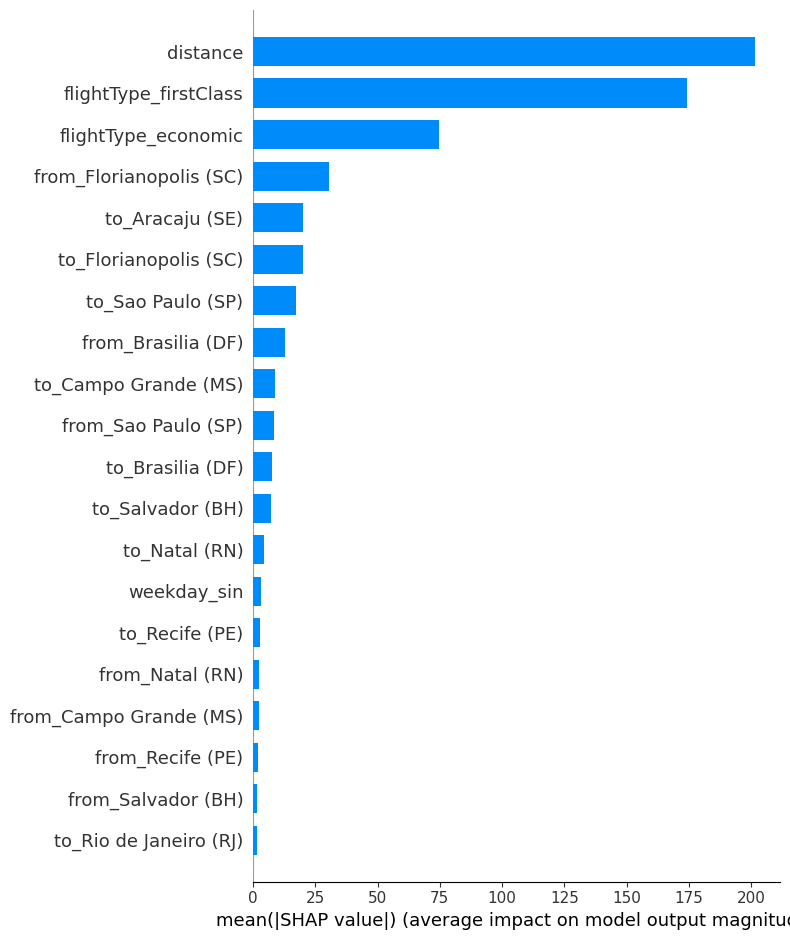

In [51]:
shap.summary_plot(shap_values, processed_X_train, plot_type="bar")

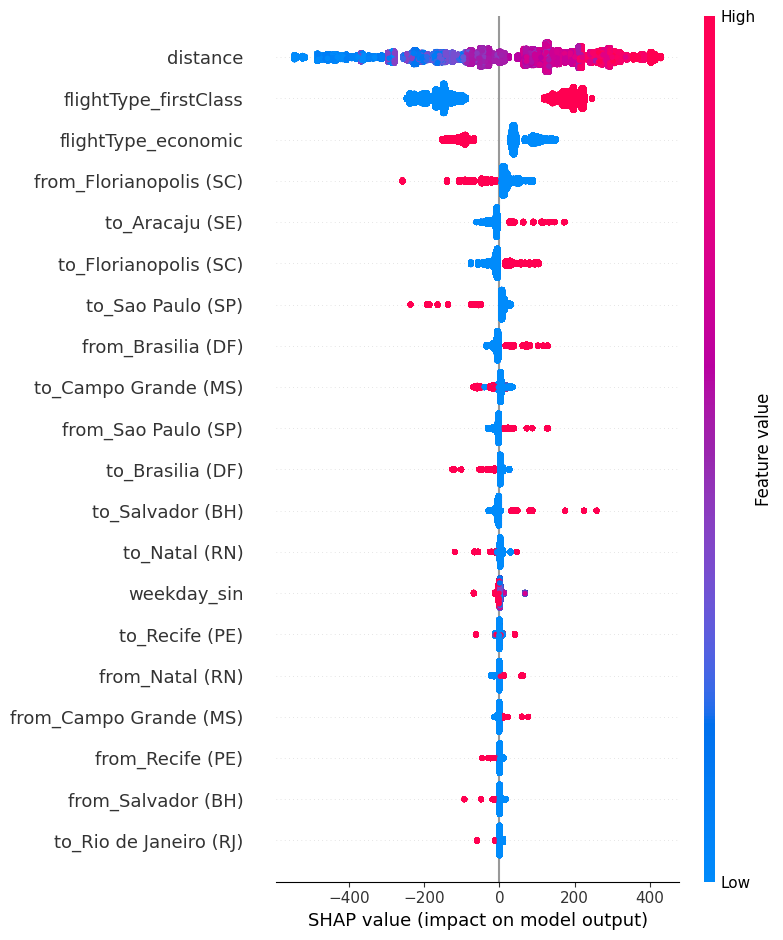

In [52]:
shap.summary_plot(shap_values, processed_X_train)

From the above SHAP explainer graphs, it is clear that:

1. Distance travelled by the flight is the most important factor impacting flight prices. Higher the distance, greater the price.

2. The second most important factor is flightType. Firstclass flights have higher prices whweras economy flights have an inverse relationship with price.

3. The origin and destination cities have a smallimpact on the flight prices.

### 12. Sanity check.


In [53]:
# Load the File and predict unseen data.

# Load the model from the pickle file
with open('/content/drive/MyDrive/Data science/ML_Models/flight_price_preprocessor.pkl', "rb") as f:
    loaded_preprocessor = joblib.load(f)
with open('/content/drive/MyDrive/Data science/ML_Models/flight_price_predictor.pkl', "rb") as f:
    loaded_price_predictor = joblib.load(f)

# preprocessing and predicting the test data
preprocessed_data = loaded_preprocessor.fit_transform(X_test)
new_test_preds = loaded_price_predictor.predict(preprocessed_data)

# Sanity Check
mse = mean_squared_error(y_test, new_test_preds)
mae = mean_absolute_error(y_test, new_test_preds)
r2 = r2_score(y_test, new_test_preds)

print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

MSE: 2827.8839932227374
MAE: 40.49736442037418
R2 Score: 0.9785254186280596


# **Conclusion**

#### Insights from EDA

A. Statistical insights:

1. Flight prices are approximately normally distributed (median: \$900) with no outliers. First-class fares are highest at $1200, followed by premium (\$900) and economic (\$650).

2. Distance (median: 570 km) and time (median: 1.4 hrs) are slightly left-skewed and linearly related, making one redundant.

3. Customers average 200 trips, with no unusual outliers in trip frequency.

4. Rainbow and CloudFy handle 43% of flights each, while Flying Drops manages 14.3%, operating only first-class flights.

5. First-class flights make up 42% of all flights, with economic and premium contributing 29% each.

6. Rainbow and CloudFy cover over 6 million km each; Flying Drops covers just over 2 million km.

7. Florianopolis has the most flights (60,000), while Rio de Janeiro has the least (17,000). Direct flights are missing between Rio de Janeiro and Salvador.

8. Flight prices are lowest in January (\$950) and highest in May-June (\$963), with a gradual rise from 2019 to 2023. Fares peak on Mondays (\$985) and are higher on weekends.

9. Flight prices correlate positively with time and distance.




B. Business insights

1. Flying Drops’ exclusive focus on first-class flights limits its market share (14.3%); diversification into economic and premium flights could improve competitiveness.

2. Rainbow and CloudFy’s balanced flight types and market share (43% each) highlight the benefits of offering diverse services.

3. High demand in Florianopolis suggests opportunities for increased flight frequency or capacity.

4. Limited connectivity between Rio de Janeiro and Salvador indicates a potential market gap to explore.

5. Seasonal price peaks (May-June) and higher weekend fares offer opportunities for dynamic pricing strategies.

6. Optimizing routes based on the linear relationship between time and distance could reduce operational costs.

#### Insights from Regression model

1. The decision tree model effectively captures the relationships between flight prices and key factors, supported by high R² of 98% and low MAE of 40.

2. The most important factors determining  flight price are the distance and flight type.

3. Airlines can leverage this model to fine-tune pricing strategies, particularly for high-demand cities and first-class flights, while also exploring untapped opportunities in underperforming routes.